# iRprop- local optimiser

The `iRprop-` optimiser is a local method that uses the direction (but not the value) of the gradient to decide its next step.
It uses a step size for each dimension of the search space, and updates the step size at every iteration depending on the change of the gradient:

- If the gradient in direction `i` has the same sign as on the previous iteration, the step-size is increased.
- If the gradient in direction `i` has a different sign, the step-size is decreased and no step is made this iteration.

Full pseudo-code is given in the [API docs](https://pints.readthedocs.io/en/stable/optimisers/irpropmin.html) and in  Figure 3 of [this paper](https://doi.org/10.1016/S0925-2312(01)00700-7).

## Example 1: finding the bottom of a parabolic valley

As a first example we try to find the bottom of a parabola, centered at the origin:

In [1]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

To see what this function looks like, we'll use a contour plot:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.arange(-2, 2.1, 0.1)
Y = np.arange(-1, 1.1, 0.1)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)

    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'x', color='red', label='optimum', markersize=20)

Next, we'll choose a starting point for our optimisation, and plot it on the contours of the error function:

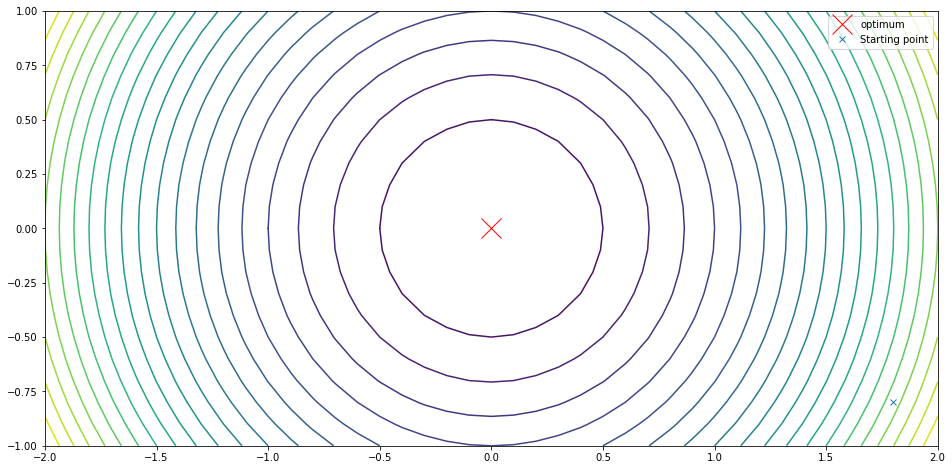

In [3]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

Now we create an optimiser and use the ask-and-tell interface to let it walk a few steps:

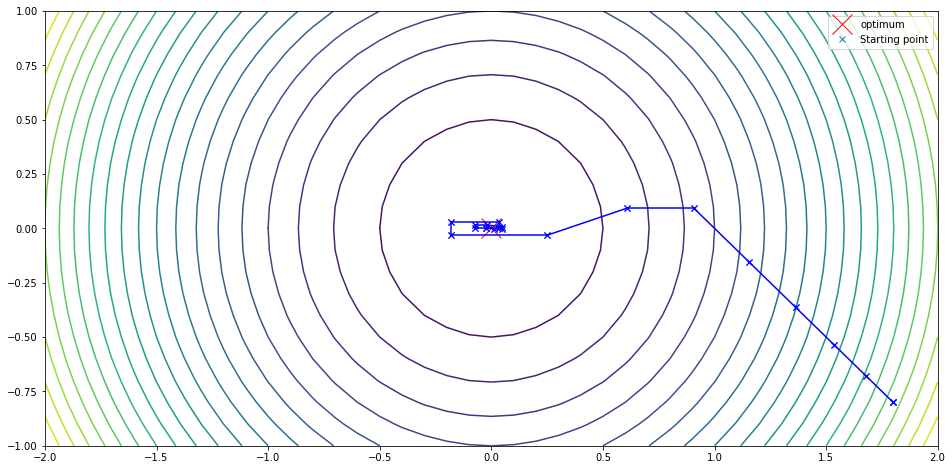

In [4]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an optimiser
opt = pints.IRPropMin(x0, 0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(20):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

This shows us that the optimiser starts off in the direction of the gradient, but does not follow it exactly.
At the 5th step the gradient in the y-direction changes sign, causing the method to wait a step, then continue in the other direction (and with a smaller step size).

Proceeding this way, it gets close to the optimum in only a few steps.

### Example 1b: Boundaries

PINTS' version of `iRprop-` extends the original algorithm with support for bounded problems. This is implemented by reducing the step size in iterations that would otherwise step out of bounds.

To visualise this, we set up some boundaries and increase the step size so that an unbounded optimisation would go beyond them:

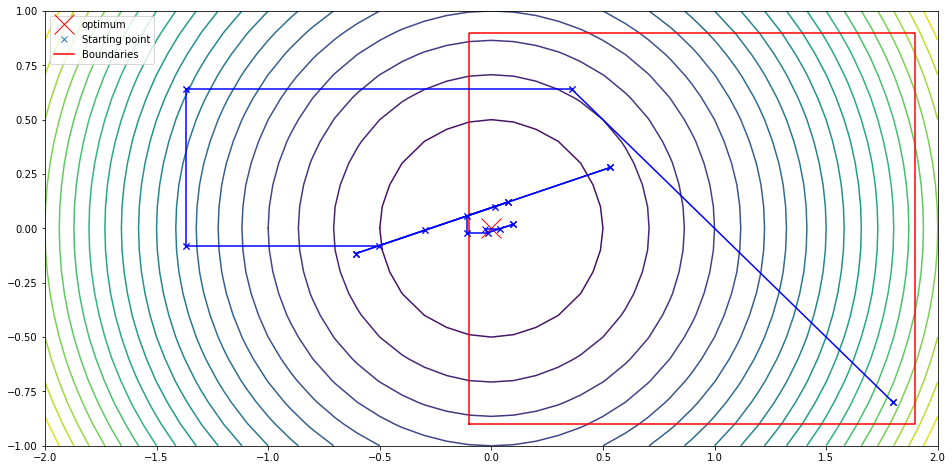

In [5]:
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Plot the boundaries
plt.plot([-0.1, 1.9, 1.9, -0.1, -0.1], [-0.9, -0.9, 0.9, 0.9, -0.9], 'red', label='Boundaries')

opt = pints.IRPropMin(x0, 1.2)
x1 = x0
for i in range(20):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

plt.legend()
plt.show()

Next, we'll create a `pints.RectangularBoundaries` object and pass it to the optimiser:

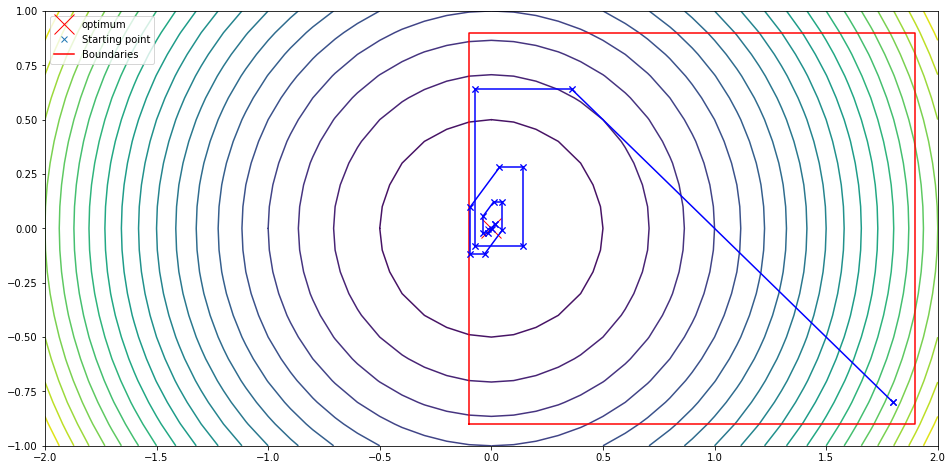

In [6]:
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')
plt.plot([-0.1, 1.9, 1.9, -0.1, -0.1], [-0.9, -0.9, 0.9, 0.9, -0.9], 'red', label='Boundaries')

# Create boundaries
b = pints.RectangularBoundaries([-0.1, -0.9], [1.9, 0.9])
opt = pints.IRPropMin(x0, 1.2, boundaries=b)

x1 = x0
for i in range(20):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

plt.legend()
plt.show()

Now we can see that the optimiser reduces its step size in the horizontal direction to avoid breaching the boundaries. The vertical step size remains unaffected.

Note that this is only possible for `pints.RectangularBoundaries`: instead of using `boundaries.check()` the optimiser can check the `lower()` and `upper()` bounds for each dimension seperately.

In the more general case, these bounds are undefined (or unknown) and so the optimiser simply reduces the step size in all directions. We can see this in action by defining a custom boundaries object. (To compare with the previous example we will use the same boundaries, but we will hide this fact from PINTS by not using the `RectangularBoundaries` class.)

In [7]:
# Create a custom boundaries class
class CustomBoundaries(pints.Boundaries):
    lo = np.array([-0.1, -0.9])
    up = np.array([1.9, 0.9])
    def n_parameters(self):
        return 2
    def check(self, x):
        return not np.any((x < self.lo) | (x >= self.up))

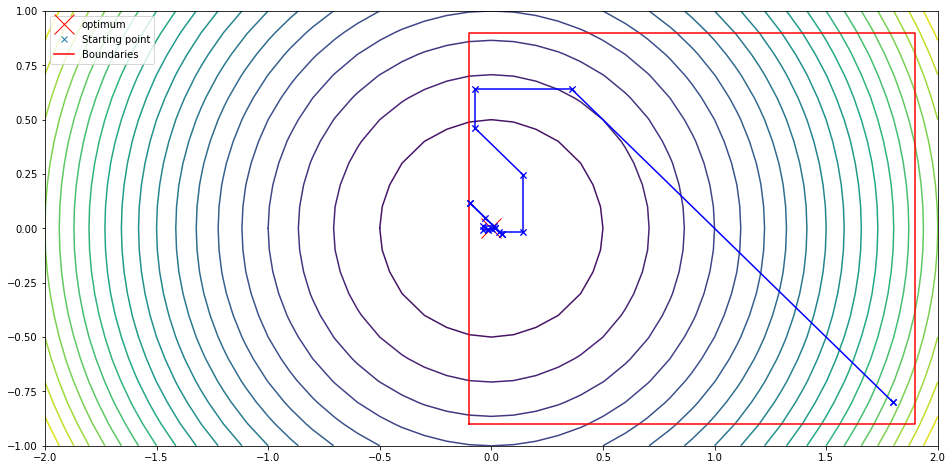

In [8]:
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')
plt.plot([-0.1, 1.9, 1.9, -0.1, -0.1], [-0.9, -0.9, 0.9, 0.9, -0.9], 'red', label='Boundaries')

# Create boundaries
b = CustomBoundaries()
opt = pints.IRPropMin(x0, 1.2, boundaries=b)

x1 = x0
for i in range(20):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

plt.legend()
plt.show()

The first two steps look the same as before, but on the third step we can now see that both the horizontal and vertical step sizes are reduced.

## Example 2: Maximising a difficult LogPDF

We'll now try `iRprop-` on the much more difficult ["banana" twisted gaussian LogPDF](https://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html).

In the formulation included in PINTS, this is implemented as a probability density function (a `LogPDF`) and so we wrap it in a [ProbabilityBasedError](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ProbabilityBasedError) to create an error measure we can minimise.

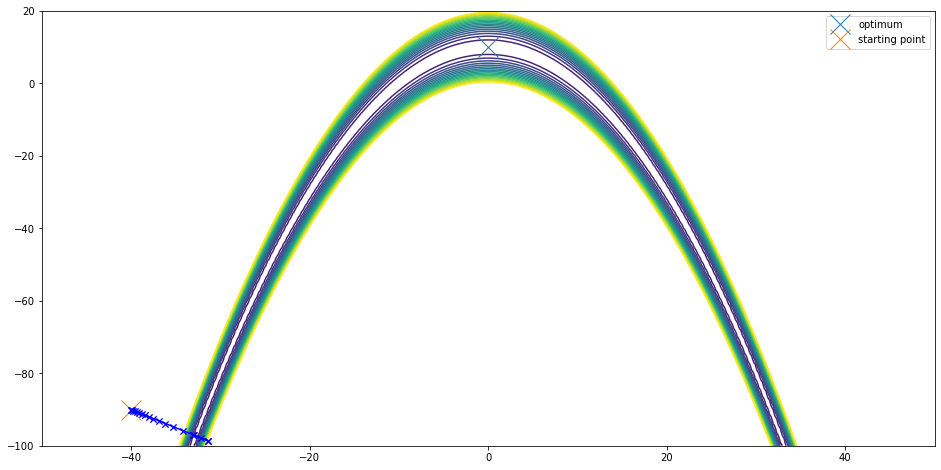

In [9]:
# Define a LogPDF (a 2-dimensional twisted gaussian)
logpdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Wrap an error around the LogPDF
error = pints.ProbabilityBasedError(logpdf)

# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)

# Evaluate the error function on a grid of points
levels = np.linspace(1, 50, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)

# Show the optimum
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Pick a starting point
x0 = [-40, -90]
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Create an optimiser
opt = pints.IRPropMin(x0, 0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(20):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

As before, the optimiser quickly runs up the gradient, but now it gets stuck!

We zoom in and let it continue:

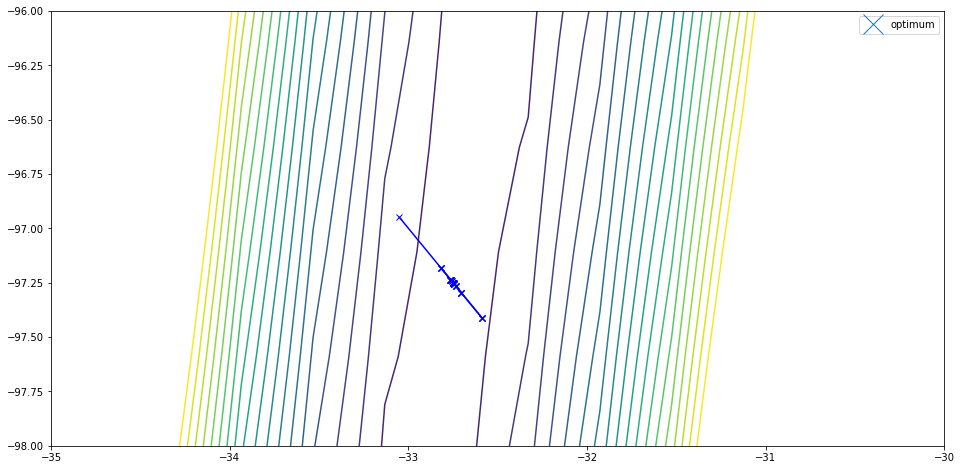

In [10]:
# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-35, -30)
plt.ylim(-98, -96)
plt.contour(X, Y, Z, levels=levels)
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Walk some more steps, and plot the results
for i in range(50):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

At this point, the gradients both point towards a very narrow skewed region. As a result, the method keeps bouncing around in a very small area, and reducing its step size. This problem is too hard for this method!

## Example 3: A noisy time-series problem

Finally, we can try applying this method to a noisy time series problem.
Note that these parameters are badly scaled: One of them is `O(0.01)` while the other is `O(100)`.
However, the adaptive step sizes are able to deal with this very well:

In [11]:
# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.IRPropMin
)
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using iRprop-
Running in sequential mode.
Iter. Eval. Best      Current   Min. step Max. step Time m:s
0     1      1.93e+07  1.93e+07  0.004     180        0:00.0
1     2      7115323   7115323   0.002     90         0:00.0
2     3      7115323   7115323   0.002     90         0:00.0
3     4      4399110   4399110   0.001     108        0:00.0
20    21     109361.1  109361.1  3.89e-05  1.7496     0:00.0
40    41     107878.8  107880    3.33e-06  0.0118     0:00.0
60    61     107878.5  107879.7  3.33e-06  1.15e-05   0:00.0
80    81     107878.5  107879.7  3.33e-06  3.33e-06   0:00.0
100   101    107878.5  107879.7  3.33e-06  3.33e-06   0:00.0
120   121    107878.5  107879.7  3.33e-06  3.33e-06   0:00.0
140   141    107878.5  107879.7  3.33e-06  3.33e-06   0:00.0
160   161    107878.5  107879.7  3.33e-06  3.33e-06   0:00.0
180   181    107878.5  107879.7  3.33e-06  3.33e-06   0:00.0
200   201    107878.5  107879.7  3.33e-06  3.33e-06   0:00.0
220   221    10787